## AnoGAN 구현 - Casting data

- 이미지 사이즈 128
- 채널 수 1


원 코드 출처 : https://github.com/mullue/anogan-mnist/blob/master/dcgan%2Banogan.ipynb

이 코드를 기반으로 모델 구조 수정, 새 데이터 적용

### Module install & import



In [ ]:
pip install -q tensorflow-gpu==2.0.0-rc1

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
from tensorflow.keras.layers import *

### Dataset loading and preparing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/[대학원] 고급통계 프로젝트/data2_casting

/content/drive/MyDrive/[대학원] 고급통계 프로젝트/data2_casting


In [ ]:
#Path of cloud and Non-cloud datasets
path_train = './train/ok_front'
path_ok_test = './test/ok_front'
path_notok_test = './test/def_front'

In [ ]:
from tqdm import tqdm

#Loaded and Preprocessed all the non-cloud satellite images for training
train_images=[]
import os
img_list = os.listdir(path_train)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path_train+'/'+str(i), target_size=(128,128),color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img - 127.5) / 127.5 # 이미지 정규화 : -1과 1 사이의 값으로 줄여서 계산을 단순하게
    train_images.append(img)
    
train_images= np.array(train_images)
train_images.shape

100%|██████████| 2875/2875 [00:18<00:00, 152.84it/s]


(2875, 128, 128, 1)

In [ ]:
from tqdm import tqdm

#Loaded and Preprocessed all the non-cloud satellite images for training
test_images=[]
import os
img_list = os.listdir(path_ok_test)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path_ok_test+'/'+str(i),target_size=(128,128),color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img - 127.5) / 127.5
    test_images.append(img)
    
test_images= np.array(test_images)
test_images.shape

100%|██████████| 262/262 [00:02<00:00, 125.78it/s]


(262, 128, 128, 1)

In [ ]:
from tqdm import tqdm

#Loaded and Preprocessed all the non-cloud satellite images for training
notok_images=[]
import os
img_list = os.listdir(path_notok_test)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path_notok_test+'/'+str(i),target_size=(128,128),color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = (img - 127.5) / 127.5
    notok_images.append(img)
    
notok_images= np.array(notok_images)
notok_images.shape

100%|██████████| 453/453 [00:02<00:00, 169.86it/s]


(453, 128, 128, 1)

In [ ]:
# train 이미지를 고르게 섞는 것
# bufferSize: shuffle(데이터 섞기)을 하기 위해 필요한 공간의 크기 - 섞을 데이터 개수보다 크게
# batch_size: 한번에 학습할 데이터의 수 (이미지의 수) - 컴퓨터가 감당하지 못하면 줄일 것
BUFFER_SIZE = 3000
BATCH_SIZE = 32

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None)>


### Model 구조

#### generator
latent variable z로 부터 이미지 사이즈 64x64x3을 생성하기 위한 업샘플링 진행

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (4,4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (4,4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
make_generator_model().summary()

Model: "sequential_320"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_321 (Dense)           (None, 16384)             1638400   
                                                                 
 batch_normalization_20 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 re_lu_20 (ReLU)             (None, 16384)             0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 8, 8, 512)        8388608   
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 8, 8, 512)     

아직 훈련되지 않은 생성자를 사용하여 이미지 생성해보기

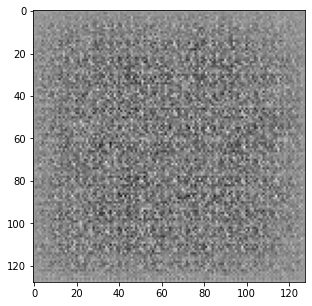

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)

plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

In [ ]:
print(generated_image.shape)

(1, 128, 128, 1)


#### Discriminator
original CNN 구조를 가진 Discriminator - 진짜/가짜 이미지 분류기

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32,(4,4),strides=(2,2), padding='same', input_shape=[128,128,1]))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(1024, (4,4), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
make_discriminator_model().summary()

Model: "sequential_322"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1896 (Conv2D)        (None, 64, 64, 32)        544       
                                                                 
 leaky_re_lu_1896 (LeakyReLU  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout_1896 (Dropout)      (None, 64, 64, 32)        0         
                                                                 
 conv2d_1897 (Conv2D)        (None, 32, 32, 64)        32832     
                                                                 
 leaky_re_lu_1897 (LeakyReLU  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout_1897 (Dropout)      (None, 32, 32, 64)     

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별, 진짜 이미지는 양수값, 가짜 이미지는 음수값 출력

In [ ]:
discriminator = make_discriminator_model()
desicion = discriminator(generated_image) # discriminator 결과로 이상치는 음수, 정상 이미지는 양수로 나와야 한다
print(desicion)

tf.Tensor([[-8.656903e-06]], shape=(1, 1), dtype=float32)


#### loss function & optimizer

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

- discriminator loss

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 진짜는 진짜로 분류되는지 - 진짜가 1
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 가짜는 가짜로 분류되는지 - 가짜가 0
  total_loss = real_loss + fake_loss
  return total_loss

- generator loss

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output) # 가짜를 진짜로 속일 수 있는지

- optimizer of G and D

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### G, D 학습

In [ ]:
def save_models(epoch, discriminator, generator, path='/content'):
    discriminator.save_weights('{}/d-{}.ckpt'.format(path,epoch))
    generator.save_weights('{}/g-{}.ckpt'.format(path,epoch))

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # z 노이즈 생성

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # 노이즈로 가짜 이미지 생성

      real_output = discriminator(images, training=True) # 가짜 이미지
      fake_output = discriminator(generated_images, training=True) # 진짜 이미지

      gen_loss = generator_loss(fake_output) # G의 loss
      disc_loss = discriminator_loss(real_output, fake_output) # D의 loss

    # trainable_variables은 이 모델의 훈련시킬 파라미터
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # G의 gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # D의 gradient

    # G와 D 최적화
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    #if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  # save weights
  save_models(epochs, discriminator, generator, '/content')

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

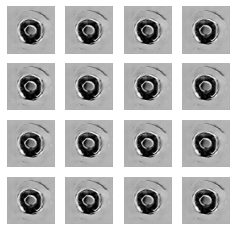

In [ ]:
#%%time
train(train_dataset, EPOCHS)

#### 각 이미지에 대한 z 학습



(1) size 100의 임의의 z를 입력받습니다.

(2) 입력된 z는 Dense layer를 지나 generator에 입력하기 위한 latent vector를 생성합니다.

(3) latent vector는 fix된 generator를 거쳐 임의의 이미지를 생성합니다.

(4) 3)의 결과를 입력으로 하여 fix된 Discriminnator를 거쳐 Real/Fake 판단을 위한 feature vector를 생성합니다.

(5) normal/abnormal 판단을 위한 이미지를 이용하여 3), 4)에 대한 Ground truth 값을 생성합니다. (이미지 자체는 3)의 ground truth 역할을 하고, 해당 이미지로부터 Discriminator 연산을 통해 생성한 feature vector는 4)에 대한 ground truth가 됩니다.)

(6) 생성된 (a), (b) 값을 ground truth와 비교하여 2)의 Dense layer를 학습합니다.

(7) 학습과정에서 사용했던 데이터(정상데이터)일 수록 학습이 더 잘 될 것입니다. 이런 원리로 6) training 작업 loss 자체가 abnoaly score 역할을 할 수 있습니다.

AnoGAN 생성시 이전 단계에서 학습된 Generator와 Discriminator 네트워크와 Weight를 로드하여 사용합니다. 아래에서 호출하고 있는 make_discriminator_model()와 make_generator_model()는 앞서 DCGAN학습단계에서 생성한 동일한 함수입니다.

In [ ]:
#Discriminator 로부터 feature 를 도출하는 함수
from tensorflow.keras.models import Model

def feature_extractor(img_shape=(128,128,3)):
    d = make_discriminator_model()
    d.load_weights('/content/d-100.ckpt') #discriminator model weigth 저장된 파일(fixed D)
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-6].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

In [ ]:
#임의의 z로부터 latent vector를 생성하고 Generator와 앞서 feature_extractor를 호출합니다.
from tensorflow.keras.layers import Layer, Input, Dense, Flatten

def gne_anogan(loss, latent_dim = 100, channels = 1, img_shape=(128,128,3)):
  g = make_generator_model()
  g.load_weights('/content/g-100.ckpt')
  g.trainable = False # G 고정
  intermidiate_model = feature_extractor(img_shape)
  intermidiate_model.trainable = False # D 고정

  z = Input(shape=(100,)) # z 하나 생성
  gInput = Dense((100))(z) # G(z)
  G_out = g(gInput)
  D_out = intermidiate_model(G_out) # G(z)를 D에 통과시켜
  model = Model(inputs=z, outputs=[G_out, D_out])
  model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')

  return model

In [ ]:
def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

In [ ]:
model = gne_anogan(loss=sum_of_residual)
model.summary()

Model: "model_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_327 (Dense)           (None, 100)               10100     
                                                                 
 sequential_324 (Sequential)  (None, 128, 128, 1)      11538688  
                                                                 
 model_313 (Functional)      (None, 4, 4, 512)         2786784   
                                                                 
Total params: 14,335,572
Trainable params: 10,100
Non-trainable params: 14,325,472
_________________________________________________________________


- 정상 데이터 테스팅

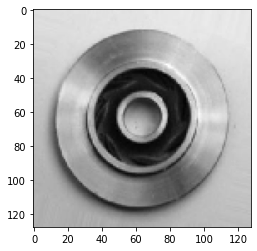

In [ ]:
nimg = train_images[17].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((nimg* 127.5 + 127.5).astype(int), cmap = 'gray')

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = nimg.reshape(1,128,128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss = model.fit(z, [x, d_x], epochs=200, verbose=0)

CPU times: user 3.74 s, sys: 113 ms, total: 3.85 s
Wall time: 3.96 s


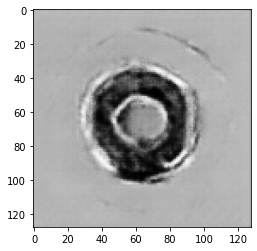

In [ ]:
o1, o2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow((o1.reshape(128,128)*127.5+127.5).astype(int), cmap = 'gray')

In [ ]:
loss.history['loss'][-1]

4259.107421875

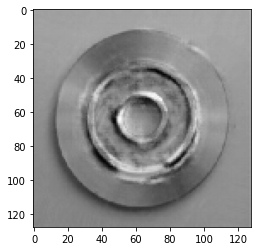

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((nimg - o1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

In [ ]:
discriminator = make_discriminator_model()
desicion = discriminator(o1) # discriminator 결과로 이상치는 음수, 정상 이미지는 양수로 나와야 한다
print(desicion)

tf.Tensor([[0.00783044]], shape=(1, 1), dtype=float32)


- 이상 데이터 테스트


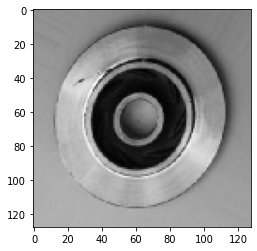

In [ ]:
aimg = notok_images[2].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((aimg*127.5+127.5).astype(int), cmap = 'gray')

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = aimg.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

CPU times: user 2.2 s, sys: 143 ms, total: 2.34 s
Wall time: 2.12 s


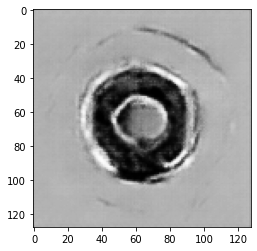

In [ ]:
oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

In [ ]:
loss_a.history['loss'][-1]

4000.455322265625

residual에 대한 시각적 표현

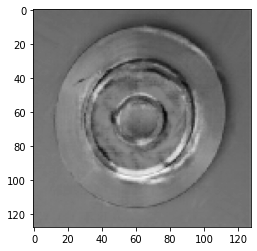

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((aimg - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

In [ ]:
discriminator = make_discriminator_model()
desicion = discriminator(oa1) # discriminator 결과로 이상치는 음수, 정상 이미지는 양수로 나와야 한다
print(desicion)

tf.Tensor([[0.00726811]], shape=(1, 1), dtype=float32)


#### 결과

각 100건의 정상과 비정상 이미지를 이용하여 Anobal loss를 비교해봅니다.

- train 정상 이미지


In [ ]:
nimg_multi = train_images[:100]

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = nimg_multi.reshape(100,128,128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal = model.fit(z, [x, d_x], epochs=200, verbose=0)

CPU times: user 29.4 s, sys: 342 ms, total: 29.7 s
Wall time: 41.3 s


- test 이상치 이미지

In [ ]:
aimg_multi = notok_images[:100]

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = aimg_multi.reshape(100,128,128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_abnormal = model.fit(z, [x, d_x], epochs=200, verbose=0)

CPU times: user 29.2 s, sys: 310 ms, total: 29.5 s
Wall time: 42.2 s


- test 정상 이미지

In [ ]:
test_multi = test_images[:100]

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(100, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = test_multi.reshape(100,128,128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_normal_test = model.fit(z, [x, d_x], epochs=200, verbose=0)

CPU times: user 30.4 s, sys: 340 ms, total: 30.7 s
Wall time: 41.3 s


plot 을 그려 정상 데이터와 비정상 데이터의 loss 값 시각화

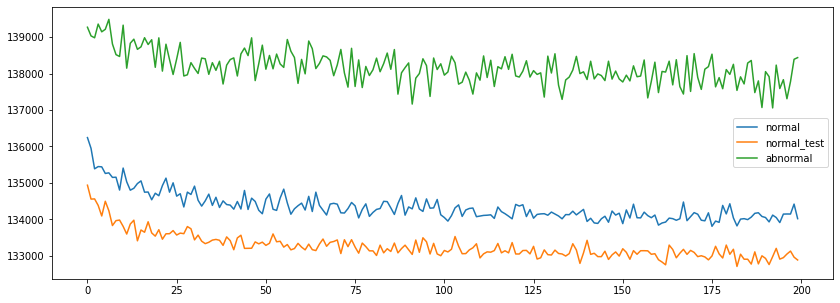

In [ ]:
plt.plot(loss_normal.history['loss'])
plt.plot(loss_normal_test.history['loss'])
plt.plot(loss_abnormal.history['loss'])
plt.legend(['normal','normal_test','abnormal'])
plt.show()

비정상 데이터의 loss 값이 더 높은 것을 확인할 수 있음

## 결과 - 각 이미지의 loss 확인

#### train data

In [ ]:
train_loss = []
for i in range(100): 
    %%time
    aimg = train_images[i]
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(img_shape=(128,128))

    # ground truth
    x = aimg.reshape(1, 128, 128)
    d_x = intermidiate_model.predict(x)

    # ground truth를 예측하는 z 학습
    loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)
    
    train_loss.append(loss_a.history['loss'][-1])

- train data 중 loss가 가장 작은 경우

In [ ]:
aa = np.where(train_loss==np.min(train_loss))[0][0]
aa

86

In [ ]:
train_loss[aa]

3215.02099609375

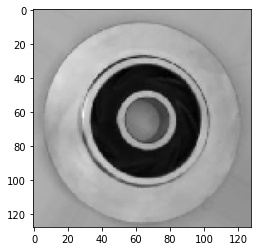

In [ ]:
temp = train_images[aa].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((temp*127.5+127.5).astype(int), cmap = 'gray')

CPU times: user 2.65 s, sys: 119 ms, total: 2.77 s
Wall time: 3.05 s


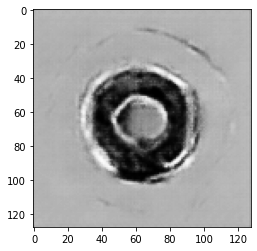

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = temp.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

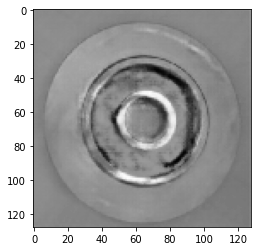

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray') #residual

- train data 중 loss가 가장 큰 경우

In [ ]:
aa = np.where(train_loss==np.max(train_loss))[0][0]
aa

20

In [ ]:
train_loss[aa]

4957.38671875

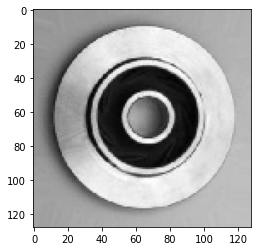

In [ ]:
temp = train_images[aa].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((temp*127.5+127.5).astype(int), cmap = 'gray')

CPU times: user 2.61 s, sys: 95.4 ms, total: 2.7 s
Wall time: 3.08 s


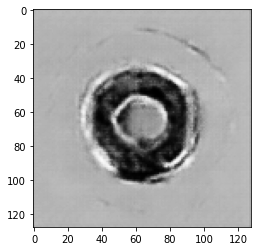

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = temp.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

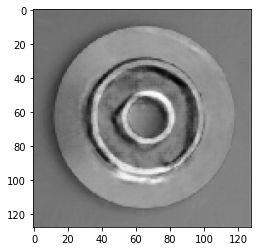

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

#### test - normal

In [ ]:
test_normal_loss = []
for i in range(100): 
    %%time
    aimg = test_images[i]
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(img_shape=(128,128))

    # ground truth
    x = aimg.reshape(1, 128, 128)
    d_x = intermidiate_model.predict(x)

    # ground truth를 예측하는 z 학습
    loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)
    
    test_normal_loss.append(loss_a.history['loss'][-1])

- test 정상 data 중 loss가 가장 작은 경우

In [ ]:
aa = np.where(test_normal_loss==np.min(test_normal_loss))[0][0]
aa

66

In [ ]:
test_normal_loss[aa]

3241.26806640625

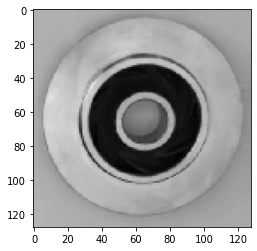

In [ ]:
temp = test_images[aa].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((temp*127.5+127.5).astype(int), cmap = 'gray')

CPU times: user 2.12 s, sys: 107 ms, total: 2.22 s
Wall time: 2.89 s


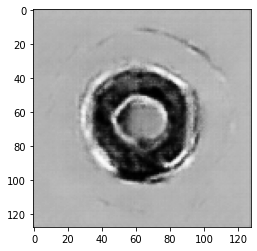

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = temp.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

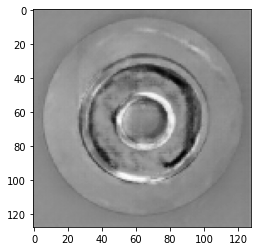

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

- test 정상 data 중 loss가 가장 큰 경우

In [ ]:
aa = np.where(test_normal_loss==np.max(test_normal_loss))[0][0]
aa

27

In [ ]:
test_normal_loss[aa]

4948.884765625

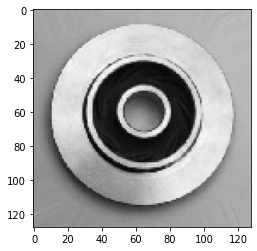

In [ ]:
temp = test_images[aa].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((temp*127.5+127.5).astype(int), cmap = 'gray')

CPU times: user 2.61 s, sys: 120 ms, total: 2.73 s
Wall time: 3.26 s


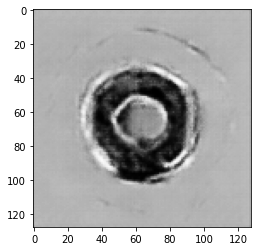

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = temp.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

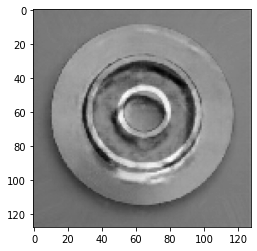

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

#### test - abnormal

In [ ]:
anomal_loss = []
for i in range(100): 
    %%time
    aimg = notok_images[i]
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor(img_shape=(128,128))

    # ground truth
    x = aimg.reshape(1, 128, 128)
    d_x = intermidiate_model.predict(x)

    # ground truth를 예측하는 z 학습
    loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)
    
    anomal_loss.append(loss_a.history['loss'][-1])

- test 이상치 data 중 loss가 가장 작은 경우

In [ ]:
aa = np.where(anomal_loss==np.min(anomal_loss))[0][0]
aa

30

In [ ]:
anomal_loss[aa]

3234.603271484375

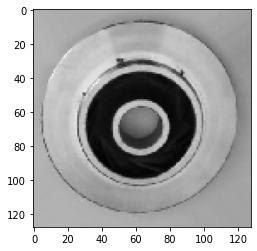

In [ ]:
temp = notok_images[aa].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((temp*127.5+127.5).astype(int), cmap = 'gray')

CPU times: user 2.07 s, sys: 101 ms, total: 2.17 s
Wall time: 2.89 s


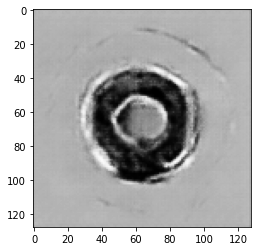

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = temp.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

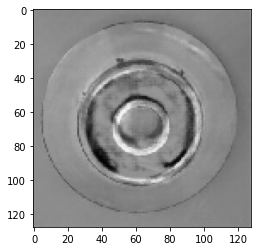

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

- test 이상치 data 중 loss가 가장 큰 경우

In [ ]:
aa = np.where(anomal_loss==np.max(anomal_loss))[0][0]
aa

61

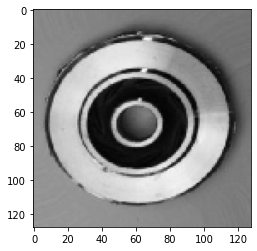

In [ ]:
temp = notok_images[aa].reshape(128,128) 
plt.figure(figsize=(4,4))
plt.imshow((temp*127.5+127.5).astype(int), cmap = 'gray')

CPU times: user 2.22 s, sys: 106 ms, total: 2.33 s
Wall time: 2.87 s


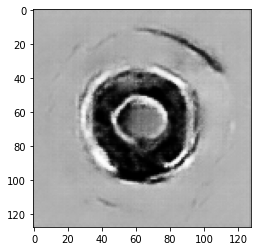

In [ ]:
%%time
z = np.random.uniform(0, 1, size=(1, 100))
intermidiate_model = feature_extractor(img_shape=(128,128))

# ground truth
x = temp.reshape(1, 128, 128)
d_x = intermidiate_model.predict(x)

# ground truth를 예측하는 z 학습
loss_a = model.fit(z, [x, d_x], epochs=200, verbose=0)

oa1, oa2 = model.predict(z)
plt.figure(figsize=(4,4))
plt.imshow(((oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

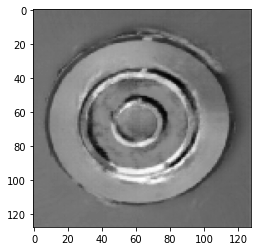

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(((temp - oa1.reshape(128,128))*127.5+127.5).astype(int), cmap = 'gray')

#### summary - all result

No handles with labels found to put in legend.


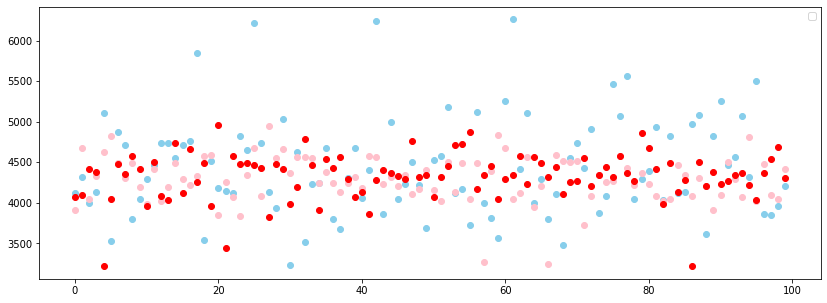

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(100), anomal_loss, c='skyblue') #skyblue는 anomal
plt.scatter(range(100), test_normal_loss, c='pink') #pink는 test normal
plt.scatter(range(100), train_loss, c='red') #red는 train
plt.legend()

No handles with labels found to put in legend.


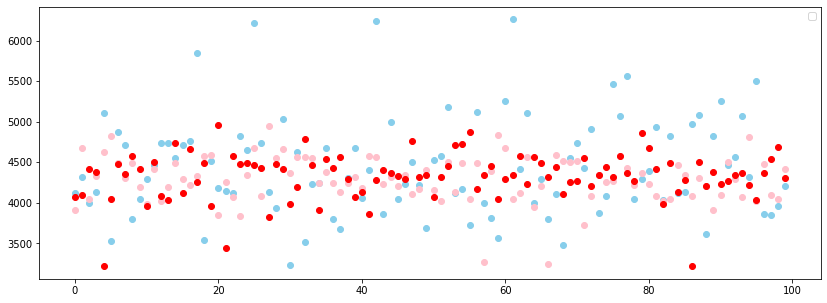

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(100), anomal_loss, c='skyblue') #skyblue는 anomal
plt.scatter(range(100), test_normal_loss, c='pink') #pink는 test normal
plt.scatter(range(100), train_loss, c='red') #red는 train
plt.legend()

In [ ]:
y_test = np.concatenate([np.zeros(shape=(100,), dtype=np.int8), np.ones(shape=(100,), dtype=np.int8), np.ones(shape=(100,), dtype=np.int8)*2])

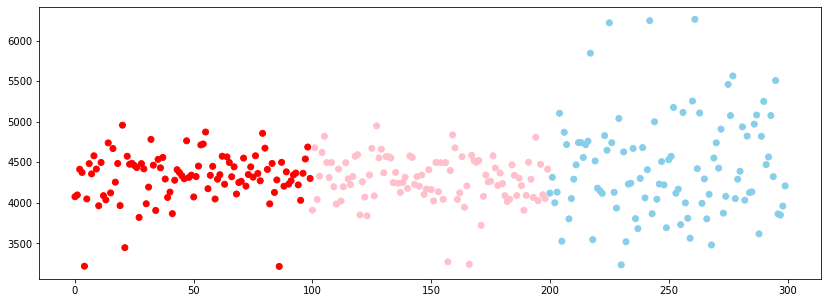

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(300), np.concatenate([train_loss, test_normal_loss, anomal_loss]), c=['red' if x == 0 else 'pink' if x==1 else 'skyblue' for x in y_test]) #skyblue는 anomal

빨간색이 train, 분홍색이 test 정상, 하늘색이 test 이상치 이미지이다. 각 그룹별 loss를 비교할 수 있다.